In [1]:
from keras.models import Model
from keras.layers import average, maximum, multiply, add

import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model, Input
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

import os
import logging
import pandas as pd
import os.path as op
from PIL import Image, ImageOps
from pathlib import Path

Using TensorFlow backend.


In [2]:
# Data properties
num_classes = 10
img_x, img_y = 128, 128

In [3]:
def load_train():
    train_images = pd.read_pickle('train_max_x')
    train_labels = pd.read_csv('train_max_y.csv').to_numpy()[:, 1]
    return train_images, train_labels

def load_test():
    return pd.read_pickle('test_max_x')

def predictions_to_csv(pred, filename):
    res = pd.Series(pred, name='Label')
    submission = pd.concat([pd.Series(range(0, res.shape[0]), name='Id'), res], axis=1)
    submission.to_csv(filename, index=False)

In [4]:
class Ensemble():
    def __init__(self, models, model_input):
        models = [model(model_input) for model in models]
        y = average(models)
        self.model = Model(inputs=model_input, outputs=y, name='ensemble')

    def predict(self, x):
        return self.model.predict(x)

    def save(self, filename):
        self.model.save(filename)

    def summary(self):
        return self.model.summary()

In [5]:
model_names = ['VGG11_2_97.22%','VGG9_97.52%', 'VGG11_97.40%', 'VGG11_96.98%', 'VGG8_2_97.45%', 'VGG8_2_97.6%', 'VGG9_97.32%', 'VGG9_97.43%']


In [6]:
# path=f'./trained_models/VGG11_97.40%.h5'
# model = load_model(path)

In [7]:
models = []
for i, name in enumerate(model_names):
    path=f'./trained_models/{name}.h5'
    print(path)
    model = load_model(path)
    print(name)
    model.name = f'ensemble_{i+1}'
    models.append(model)

./trained_models/VGG11_2_97.22%.h5
VGG11_2_97.22%
./trained_models/VGG9_97.52%.h5
VGG9_97.52%
./trained_models/VGG11_97.40%.h5
VGG11_97.40%
./trained_models/VGG11_96.98%.h5
VGG11_96.98%
./trained_models/VGG8_2_97.45%.h5
VGG8_2_97.45%
./trained_models/VGG8_2_97.6%.h5
VGG8_2_97.6%
./trained_models/VGG9_97.32%.h5
VGG9_97.32%
./trained_models/VGG9_97.43%.h5
VGG9_97.43%


Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
ensemble_1 (Sequential)         (None, 10)           6550514     input_1[0][0]                    
__________________________________________________________________________________________________
ensemble_2 (Sequential)         (None, 10)           16307306    input_1[0][0]                    
__________________________________________________________________________________________________
ensemble_3 (Sequential)         (None, 10)           22162410    input_1[0][0]                    
___________________________________________________________________________________________

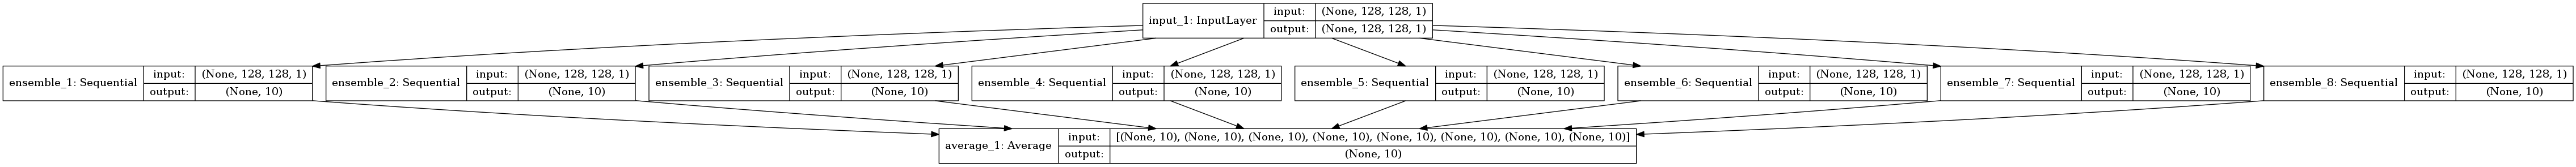

In [8]:
model_input = Input(shape=(128, 128, 1))
model = Ensemble(models, model_input)
model_name = 'ensemble'

print(model.summary())
plot_model(model.model, to_file=f'./figures/{model_name}{len(model_names)}_arch.png', show_shapes=True)

In [9]:
# Load data
train_images, train_labels = load_train()
x_test = load_test()

_, x_valid, _, y_valid = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

# Reshape and normalize
x_valid = x_valid.reshape(x_valid.shape[0], img_x, img_y, 1)
x_valid = x_valid.astype('float32')
x_valid /= 255.
print('Validation dim: ', x_valid.shape)

x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
x_test = x_test.astype('float32')
x_test /= 255.
print('Test dim: ', x_test.shape)

Validation dim:  (10000, 128, 128, 1)
Test dim:  (10000, 128, 128, 1)


In [10]:
# Compute validation accuracy
y_val_pred = model.predict(x_valid)
y_val_pred = np.argmax(y_val_pred, axis=1)
print(y_val_pred.shape)

(10000,)


In [11]:
num_correct = 0
for y, y_pred in zip(y_valid, y_val_pred):
    if y == y_pred:
        num_correct += 1
ACC=num_correct/y_valid.shape[0]*100
print('Validation Accuracy: ', ACC)

Validation Accuracy:  98.4


In [12]:
# Generate test labels
y_test = model.predict(x_test)
y_test = np.argmax(y_test, axis=1)
print(y_test.shape)
predictions_to_csv(y_test, f'{model_name}_{ACC}%_pred.csv')

plt.show()

(10000,)
